In [24]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [26]:
from convolve import convolve, nearest_power_of_two
from stu import STU
from lds_utils import compute_ar_x_preds
from lds import LDS

In [27]:
flash_fft_available = False
dtype = torch.bfloat16 if flash_fft_available else torch.float32

use_hankel_L  = False
phi = torch.tensor(np.load('spectral_filters.npy')).to(device).to(dtype)
seq_len, num_eigh = 8192, 24
# phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L, device  = device,  dtype = torch.float32)
n = nearest_power_of_two(seq_len * 2 - 1, round_up=True)

class Config:
    def __init__(self):
        self.num_eigh = num_eigh
        self.use_hankel_L = use_hankel_L
        self.torch_dtype = dtype
        self.n_embd = 1  # d_in and d_out
        self.seq_len = seq_len
        self.k_u = 0
        self.use_flash_fft = flash_fft_available
        self.use_approx = False

stu_config = Config()


***Let's first load in the LDS and STU pairs that we've trained on Della and filter out the pairs that weren't learned well***

In [28]:
import os
import torch
from pathlib import Path


def load_lds_stu_pairs(directory="../../della/lds_trained"):
    # Convert to Path object for easier path manipulation
    dir_path = Path(directory)
    
    # Dictionary to store pairs temporarily
    pairs_dict = {}
    
    # List all files in directory
    for file in dir_path.glob("*"):
        if file.suffix == '.pth':
            # Parse filename
            name = file.stem  # Get filename without extension
            if '_lds_' in name or '_stu_' in name:
                # Extract the number and type (lds/stu)
                prefix = name.split('_lds_')[0] if '_lds_' in name else name.split('_stu_')[0]
                number = name.split('_')[-1]
                model_type = 'lds' if '_lds_' in name else 'stu'
                
                # Create key for matching pairs
                key = (prefix, number)
                
                # Initialize dict entry if not exists
                if key not in pairs_dict:
                    pairs_dict[key] = {'lds': None, 'stu': None}
                
                # Load the model state dict
                model_state = torch.load(file)
                pairs_dict[key][model_type] = model_state
    
    # Convert to list of pairs, only keeping complete pairs
    pairs = []
    for key, models in pairs_dict.items():
        if models['lds'] is not None and models['stu'] is not None:
            pairs.append((models['lds'], models['stu']))
    
    return pairs

# Usage
lds_stu_pairs = load_lds_stu_pairs()

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95742/4179131590.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(file)


In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(42)
# Define a function to compute MSE between LDS and STU outputs
def compute_mse_for_pairs(pairs, seq_len=100, batch_size=1, input_dim=1):
    results = []
    
    for i, (lds, stu) in enumerate(pairs):
        # Generate Gaussian input with fixed seed for reproducibility
        
        gaussian_input = torch.randn(batch_size, seq_len, input_dim)
        
        # Set models to evaluation mode
        lds.eval()
        stu.eval()
        
        # Forward pass through both models
        with torch.no_grad():
            lds_output = lds(gaussian_input)
            stu_output = stu(gaussian_input)
            
            # Compute MSE
            mse = F.mse_loss(lds_output, stu_output).item()
            
        results.append({
            'pair_index': i,
            'mse': mse,
            'lds': lds,
            'stu': stu
        })
        
    return results

# Compute MSE for all pairs
mse_results = compute_mse_for_pairs(lds_stu_pairs)



Total pairs: 6105
Filtered pairs with MSE < 1e-5: 480


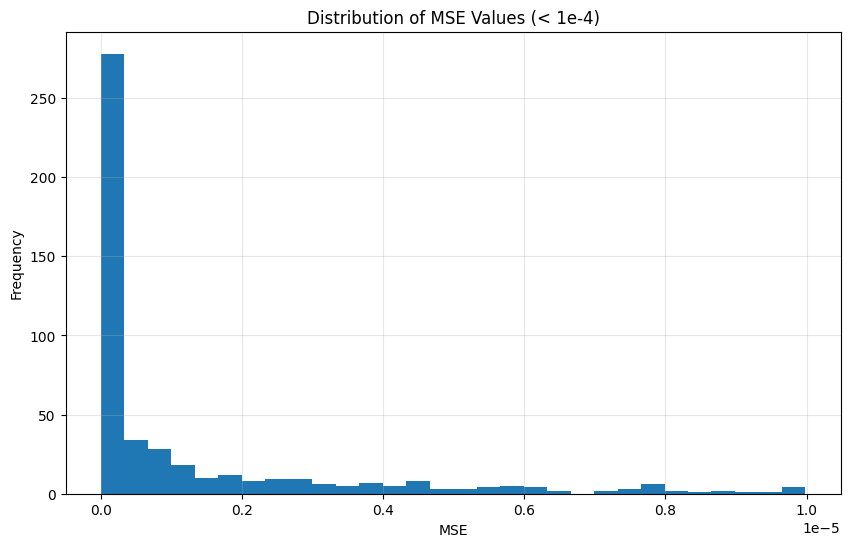

In [36]:
# Filter pairs with MSE less than 1e-4
filtered_pairs = []
for result in mse_results:
    if result['mse'] < 1e-5:
        filtered_pairs.append((result['lds'], result['stu']))

print(f"Total pairs: {len(mse_results)}")
print(f"Filtered pairs with MSE < 1e-5: {len(filtered_pairs)}")

# Create a new list of MSE values for the filtered pairs
filtered_mse = [result['mse'] for result in mse_results if result['mse'] < 1e-5]

# Plot histogram of filtered MSE values if there are any
if filtered_mse:
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_mse, bins=30)
    plt.title('Distribution of MSE Values (< 1e-4)')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No pairs with MSE < 1e-5 found.")


***Interestingly, the vast majority of pairs were not fit well. Hmmm, probably worth checking out***
**We'll first check to make sure everything looks good, and we'll investigate the rank of the system **

In [105]:

def gen_lds_impulse(lds, seq_len = seq_len): #need the stu for to add the negative autoregressive component
    lds_impulse = torch.zeros(seq_len)
    for i in range(seq_len):
        a_power = lds.A ** i
        lds_impulse[i] += torch.sum(lds.C[:, 0] * a_power * lds.B[0]).cpu()
    return lds_impulse

phi_n = phi.data.cpu().numpy()

def gen_stu_impulse(stu, seq_len = seq_len):
    alt_sign = lambda x: x * np.array([1, -1] * (seq_len//2))
    pos_coef = stu.M_phi_plus.data.cpu().numpy()[:, 0,0]
    neg_coef = stu.M_phi_minus.data.cpu().numpy()[:,0,0]
    impulse = np.sum(phi_n*pos_coef, axis = -1) + alt_sign(np.sum(phi_n*neg_coef, axis = -1))
    return impulse

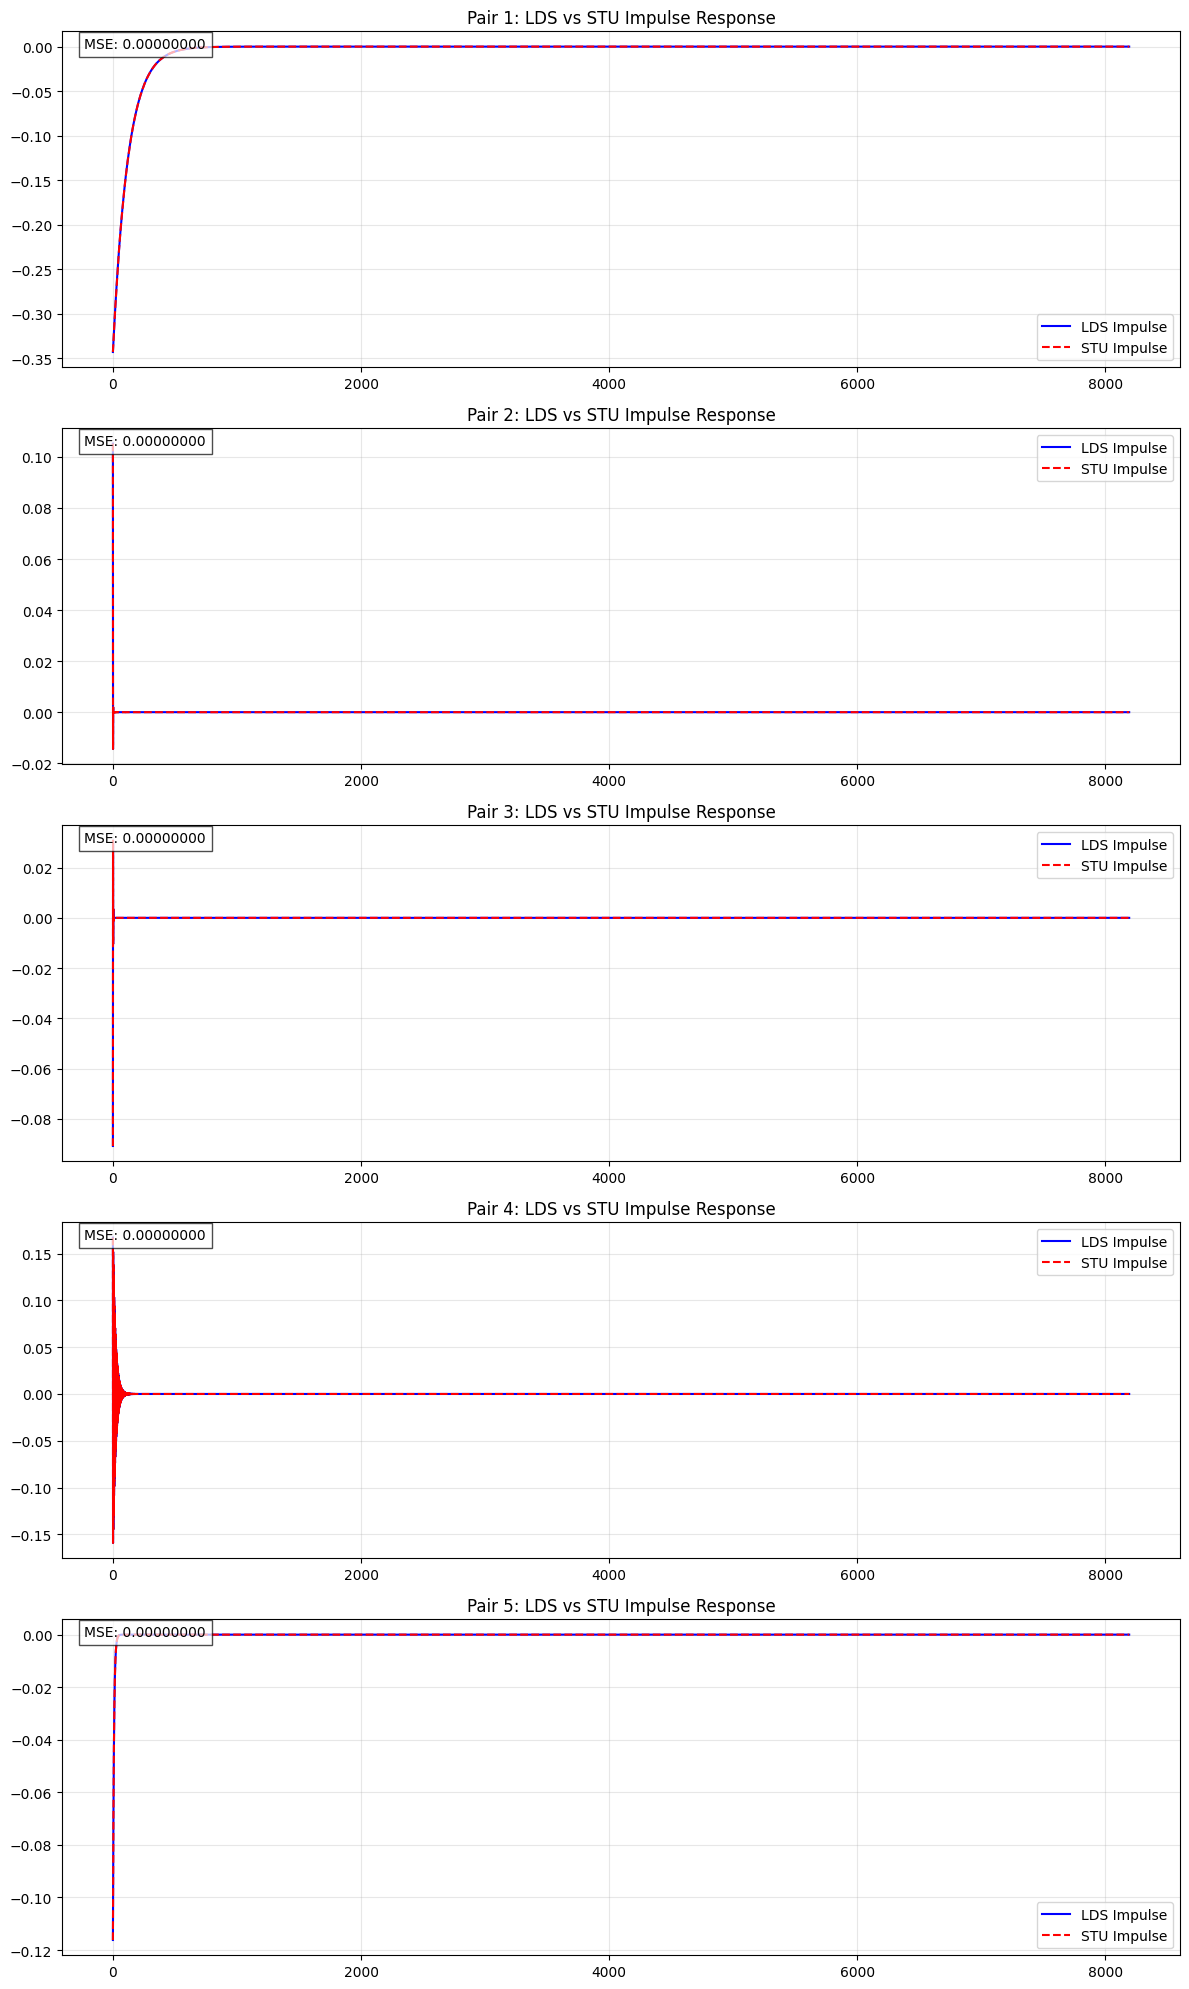

In [106]:
# Sample 20 random pairs from the filtered pairs
import random
import numpy as np
import matplotlib.pyplot as plt

# Make sure we have pairs to sample
if filtered_pairs:
    # Sample min(20, available pairs) to avoid error if we have fewer than 20 pairs
    sample_size = min(5, len(filtered_pairs))
    sampled_pairs = random.sample(filtered_pairs, sample_size)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(sample_size, 1, figsize=(12, 4*sample_size))
    
    # If only one pair is sampled, axes won't be an array
    if sample_size == 1:
        axes = [axes]
    
    # Plot each sampled pair
    for i, (lds, stu) in enumerate(sampled_pairs):
        # Generate impulse responses
        lds_impulse = gen_lds_impulse(lds)
        stu_impulse = gen_stu_impulse(stu)
        
        # Convert to numpy for plotting if needed
        if isinstance(lds_impulse, torch.Tensor):
            lds_impulse = lds_impulse.detach().numpy()
        
        # Plot on the corresponding subplot
        axes[i].plot(lds_impulse, label='LDS Impulse', color='blue')
        axes[i].plot(stu_impulse, label='STU Impulse', color='red', linestyle='--')
        axes[i].set_title(f'Pair {i+1}: LDS vs STU Impulse Response')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Calculate MSE for this pair
        mse = np.mean((lds_impulse - stu_impulse)**2)
        axes[i].text(0.02, 0.95, f'MSE: {mse:.8f}', transform=axes[i].transAxes, 
                     bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
else:
    print("No filtered pairs available to sample.")


In [33]:
# Reconstruct filters from LDS-STU pairs using pseudoinverse approach
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


print(f"Attempting to reconstruct filters from {len(filtered_pairs)} LDS-STU pairs")

# Extract LDS and STU parameters from filtered pairs
lds_params = [lds for lds, _ in filtered_pairs]
stu_params = [stu for _, stu in filtered_pairs]

# Generate impulse responses for all pairs
lds_impulses = np.array([gen_lds_impulse(lds).detach() for lds in lds_params])
stu_impulses = np.array([gen_stu_impulse(stu)for stu in stu_params])

# Convert to torch tensors
lds_impulses_tensor = torch.tensor(lds_impulses, dtype=torch.float)

# Assuming we have the combined weights from the STU parameters
# We'll construct combined_weights from STU parameters


Attempting to reconstruct filters from 480 LDS-STU pairs


Shape of lds_impulses_tensor: torch.Size([480, 8192])
Rank of LDS impulses matrix: 27
This means that out of 480 LDS impulse vectors, only 27 are linearly independent.


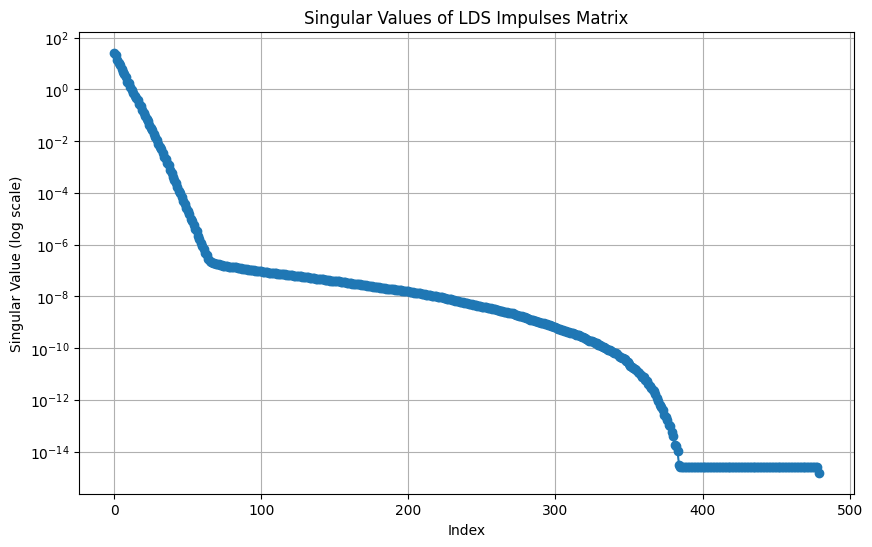

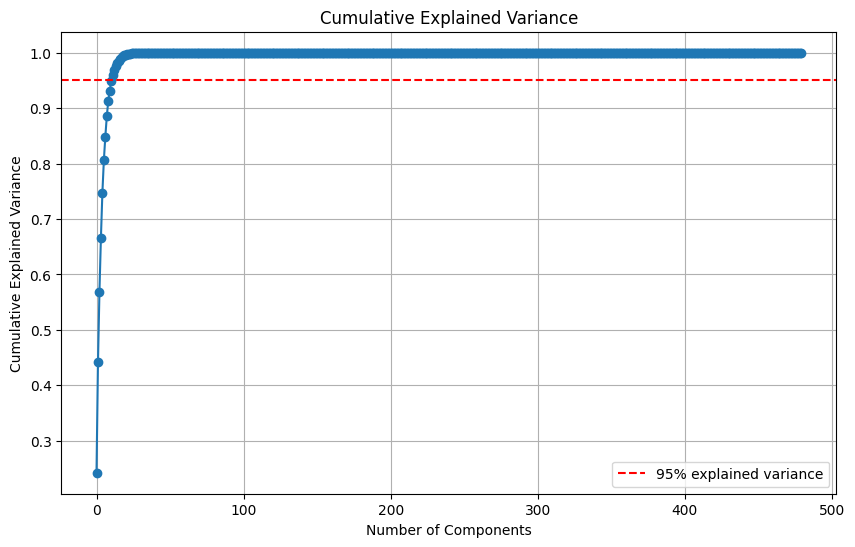

Number of components needed to explain 95% of variance: 12


In [107]:
# Calculate the rank of the LDS impulses matrix
# First, check the shape of the LDS impulses tensor
print(f"Shape of lds_impulses_tensor: {lds_impulses_tensor.shape}")

# Convert to numpy for rank calculation
lds_impulses_np = lds_impulses_tensor.numpy()

# Calculate the rank using numpy's matrix_rank function
from numpy.linalg import matrix_rank
rank = matrix_rank(lds_impulses_np)

print(f"Rank of LDS impulses matrix: {rank}")
print(f"This means that out of {lds_impulses_np.shape[0]} LDS impulse vectors, only {rank} are linearly independent.")

# Visualize the singular values to understand the effective rank
u, s, vh = np.linalg.svd(lds_impulses_np, full_matrices=False)
plt.figure(figsize=(10, 6))
plt.semilogy(s, 'o-')
plt.title('Singular Values of LDS Impulses Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True)
plt.show()

# Plot the cumulative explained variance
explained_variance = np.cumsum(s) / np.sum(s)
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

# Find how many components are needed to explain 95% of variance
components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components needed to explain 95% of variance: {components_95}")


**Now lets use the equation lds_impulse ≈ M @ phi to reach phi = M^(-1) @ lds_impulse **

In [34]:
alternating_signs = np.array([1, -1] * (seq_len//2))
phi_n_alternating = phi_n * alternating_signs[:, np.newaxis]
phi_n_combined = np.concatenate([phi_n, phi_n_alternating], axis=1)  # Shape: (1024, 40)

In [35]:
# For each STU, combine M_phi_plus and M_phi_minus
combined_weights = []
for stu in stu_params:
    # Get M_phi_plus and M_phi_minus from STU model
    M_phi_plus = stu.M_phi_plus.detach().cpu().numpy()[:,0,0]
    M_phi_minus = stu.M_phi_minus.detach().cpu().numpy()[:,0,0]
    
    # Concatenate the weights
    combined = np.concatenate([M_phi_plus, M_phi_minus], axis=0)
    combined_weights.append(combined)

# Stack all combined weights into a single array
combined_weights = np.stack(combined_weights)
combined_weights.shape

(480, 48)

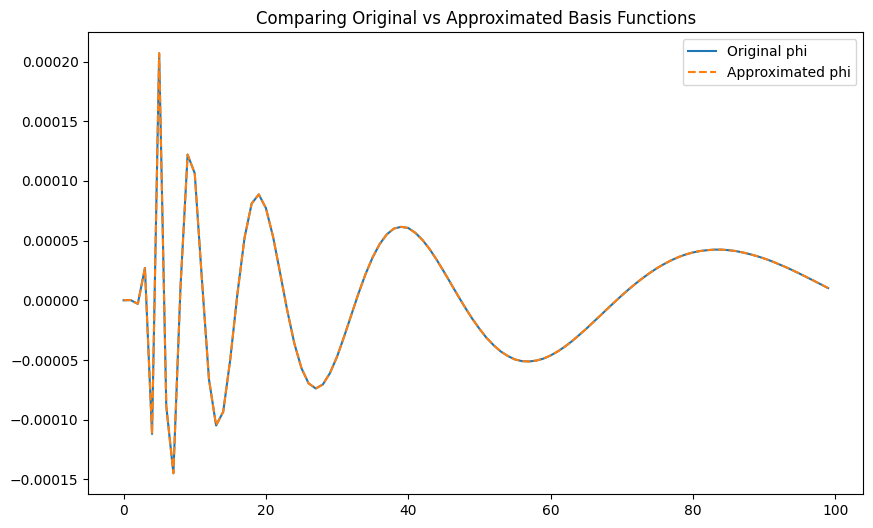

MSE between original and approximated phi: 2.30e-17


In [39]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(stu_impulses.T, combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


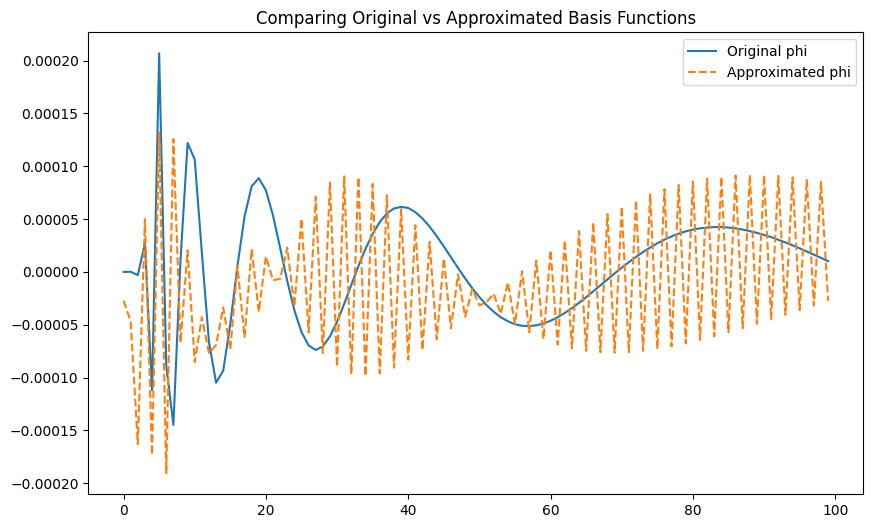

MSE between original and approximated phi: 2.29e-08


In [40]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(lds_impulses.T, combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


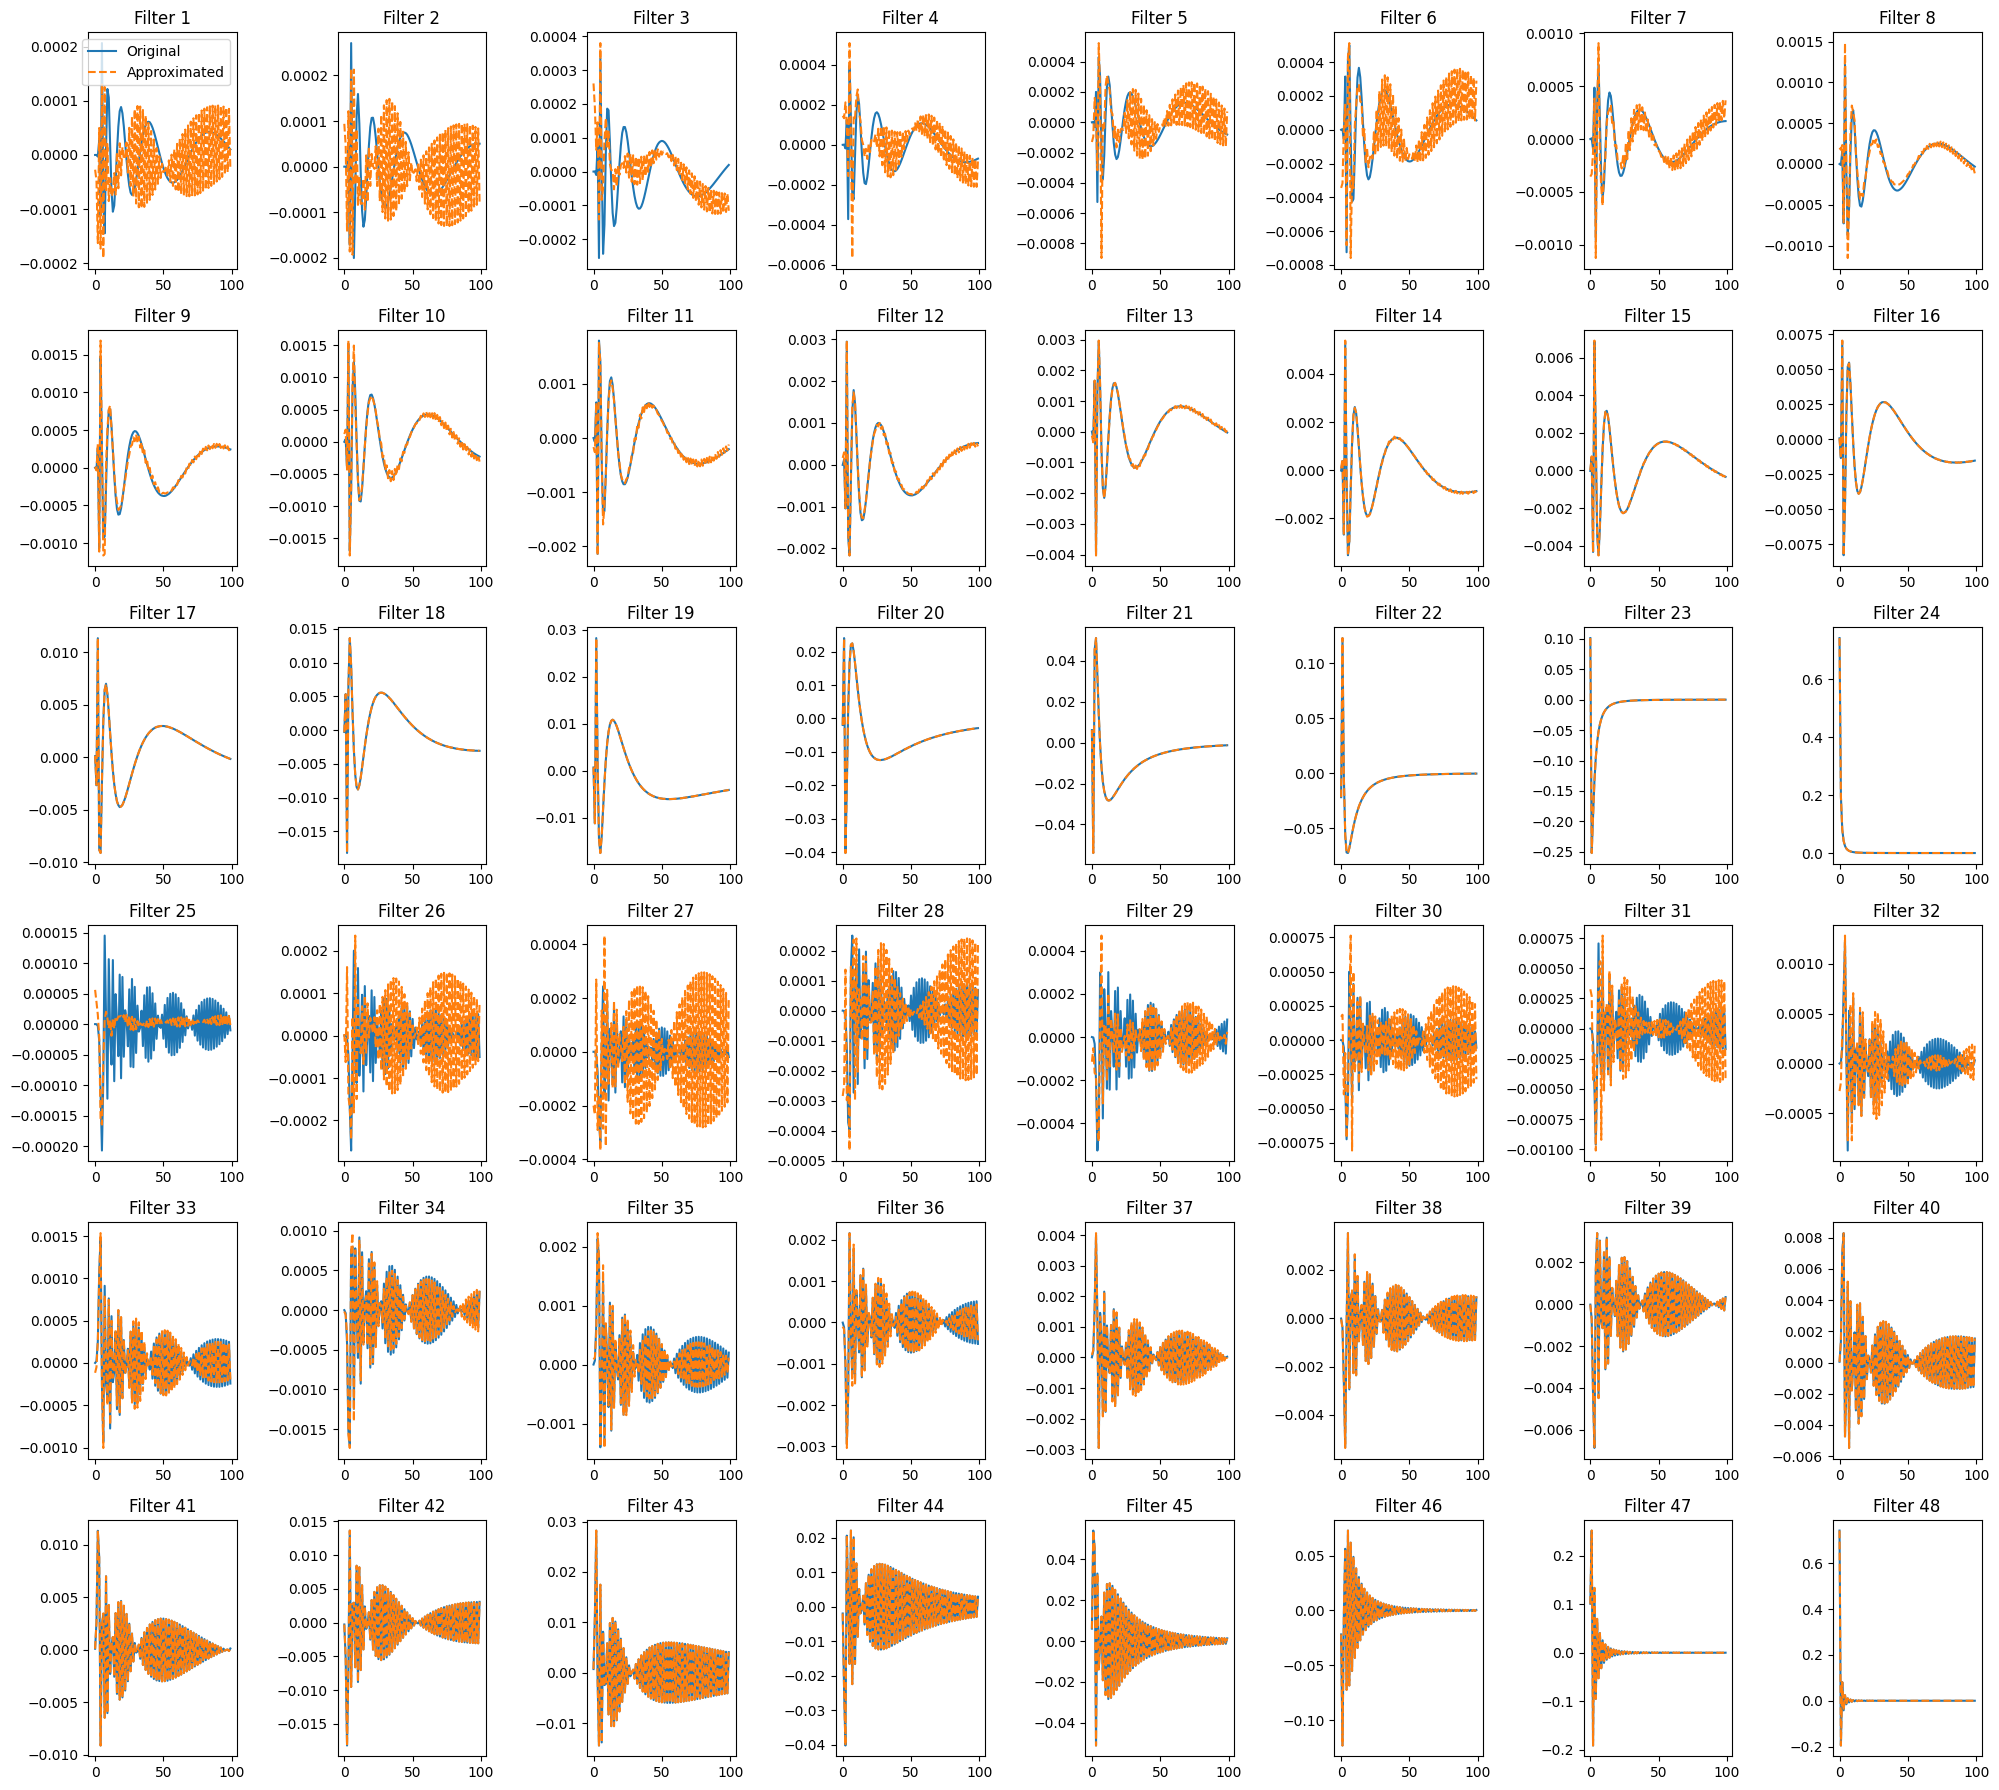

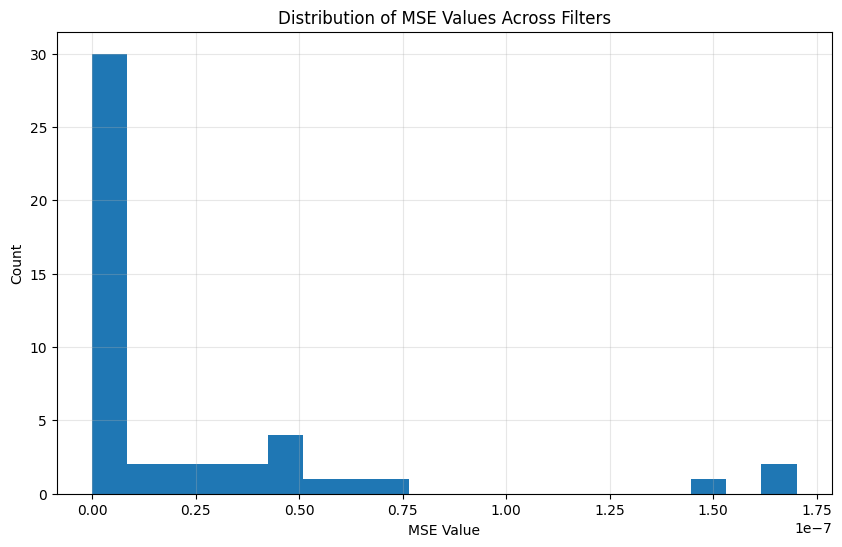

Mean MSE across filters: 2.29e-08
Median MSE across filters: 2.26e-09
Min MSE: 1.34e-12, Max MSE: 1.70e-07


In [41]:
# Plot all 48 filters to compare original vs approximated phi
num_filters = phi_n_combined.shape[1]  # Should be 48 based on previous output
num_rows = (num_filters + 7) // 8  # Arrange in 8 columns

plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_approx[:100, i], '--', label='Approximated')
    plt.title(f'Filter {i+1}')
    if i == 0:  # Only show legend on the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate MSE for each filter individually
filter_mses = []
for i in range(num_filters):
    filter_mse = F.mse_loss(
        torch.tensor(phi_n_combined[:, i]), 
        torch.tensor(phi_n_approx[:, i])
    )
    filter_mses.append(filter_mse.item())

# Plot histogram of per-filter MSE values
plt.figure(figsize=(10, 6))
plt.hist(filter_mses, bins=20)
plt.xlabel('MSE Value')
plt.ylabel('Count')
plt.title('Distribution of MSE Values Across Filters')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print(f"Mean MSE across filters: {np.mean(filter_mses):.2e}")
print(f"Median MSE across filters: {np.median(filter_mses):.2e}")
print(f"Min MSE: {np.min(filter_mses):.2e}, Max MSE: {np.max(filter_mses):.2e}")


***Now lets use gradient descent to improve this fit***

Starting gradient descent optimization...
Step 0/500000, Loss: 2.29e-08
Step 5000/500000, Loss: 5.64e-10
Step 10000/500000, Loss: 3.74e-10
Step 15000/500000, Loss: 3.02e-10
Step 20000/500000, Loss: 2.61e-10
Step 25000/500000, Loss: 2.35e-10
Step 30000/500000, Loss: 2.16e-10
Step 35000/500000, Loss: 2.02e-10
Step 40000/500000, Loss: 1.91e-10
Step 45000/500000, Loss: 1.81e-10
Step 50000/500000, Loss: 1.74e-10
Step 55000/500000, Loss: 1.67e-10
Step 60000/500000, Loss: 1.61e-10
Step 65000/500000, Loss: 1.56e-10
Step 70000/500000, Loss: 1.51e-10
Step 75000/500000, Loss: 1.47e-10
Step 80000/500000, Loss: 1.43e-10
Step 85000/500000, Loss: 1.40e-10
Step 90000/500000, Loss: 1.37e-10
Step 95000/500000, Loss: 1.34e-10
Step 100000/500000, Loss: 1.31e-10
Step 105000/500000, Loss: 1.28e-10
Step 110000/500000, Loss: 1.26e-10
Step 115000/500000, Loss: 1.23e-10
Step 120000/500000, Loss: 1.21e-10
Step 125000/500000, Loss: 1.19e-10
Step 130000/500000, Loss: 1.17e-10
Step 135000/500000, Loss: 1.15e-10
Ste

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95742/3800471474.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_improved = lds_impulses_tensor.T @ optimized_weights
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95742/3800471474.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(phi_n_improved)


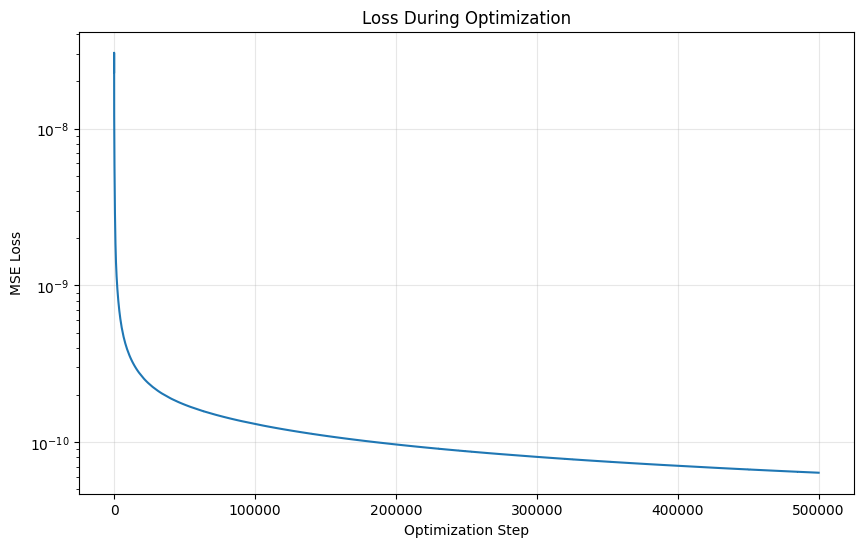

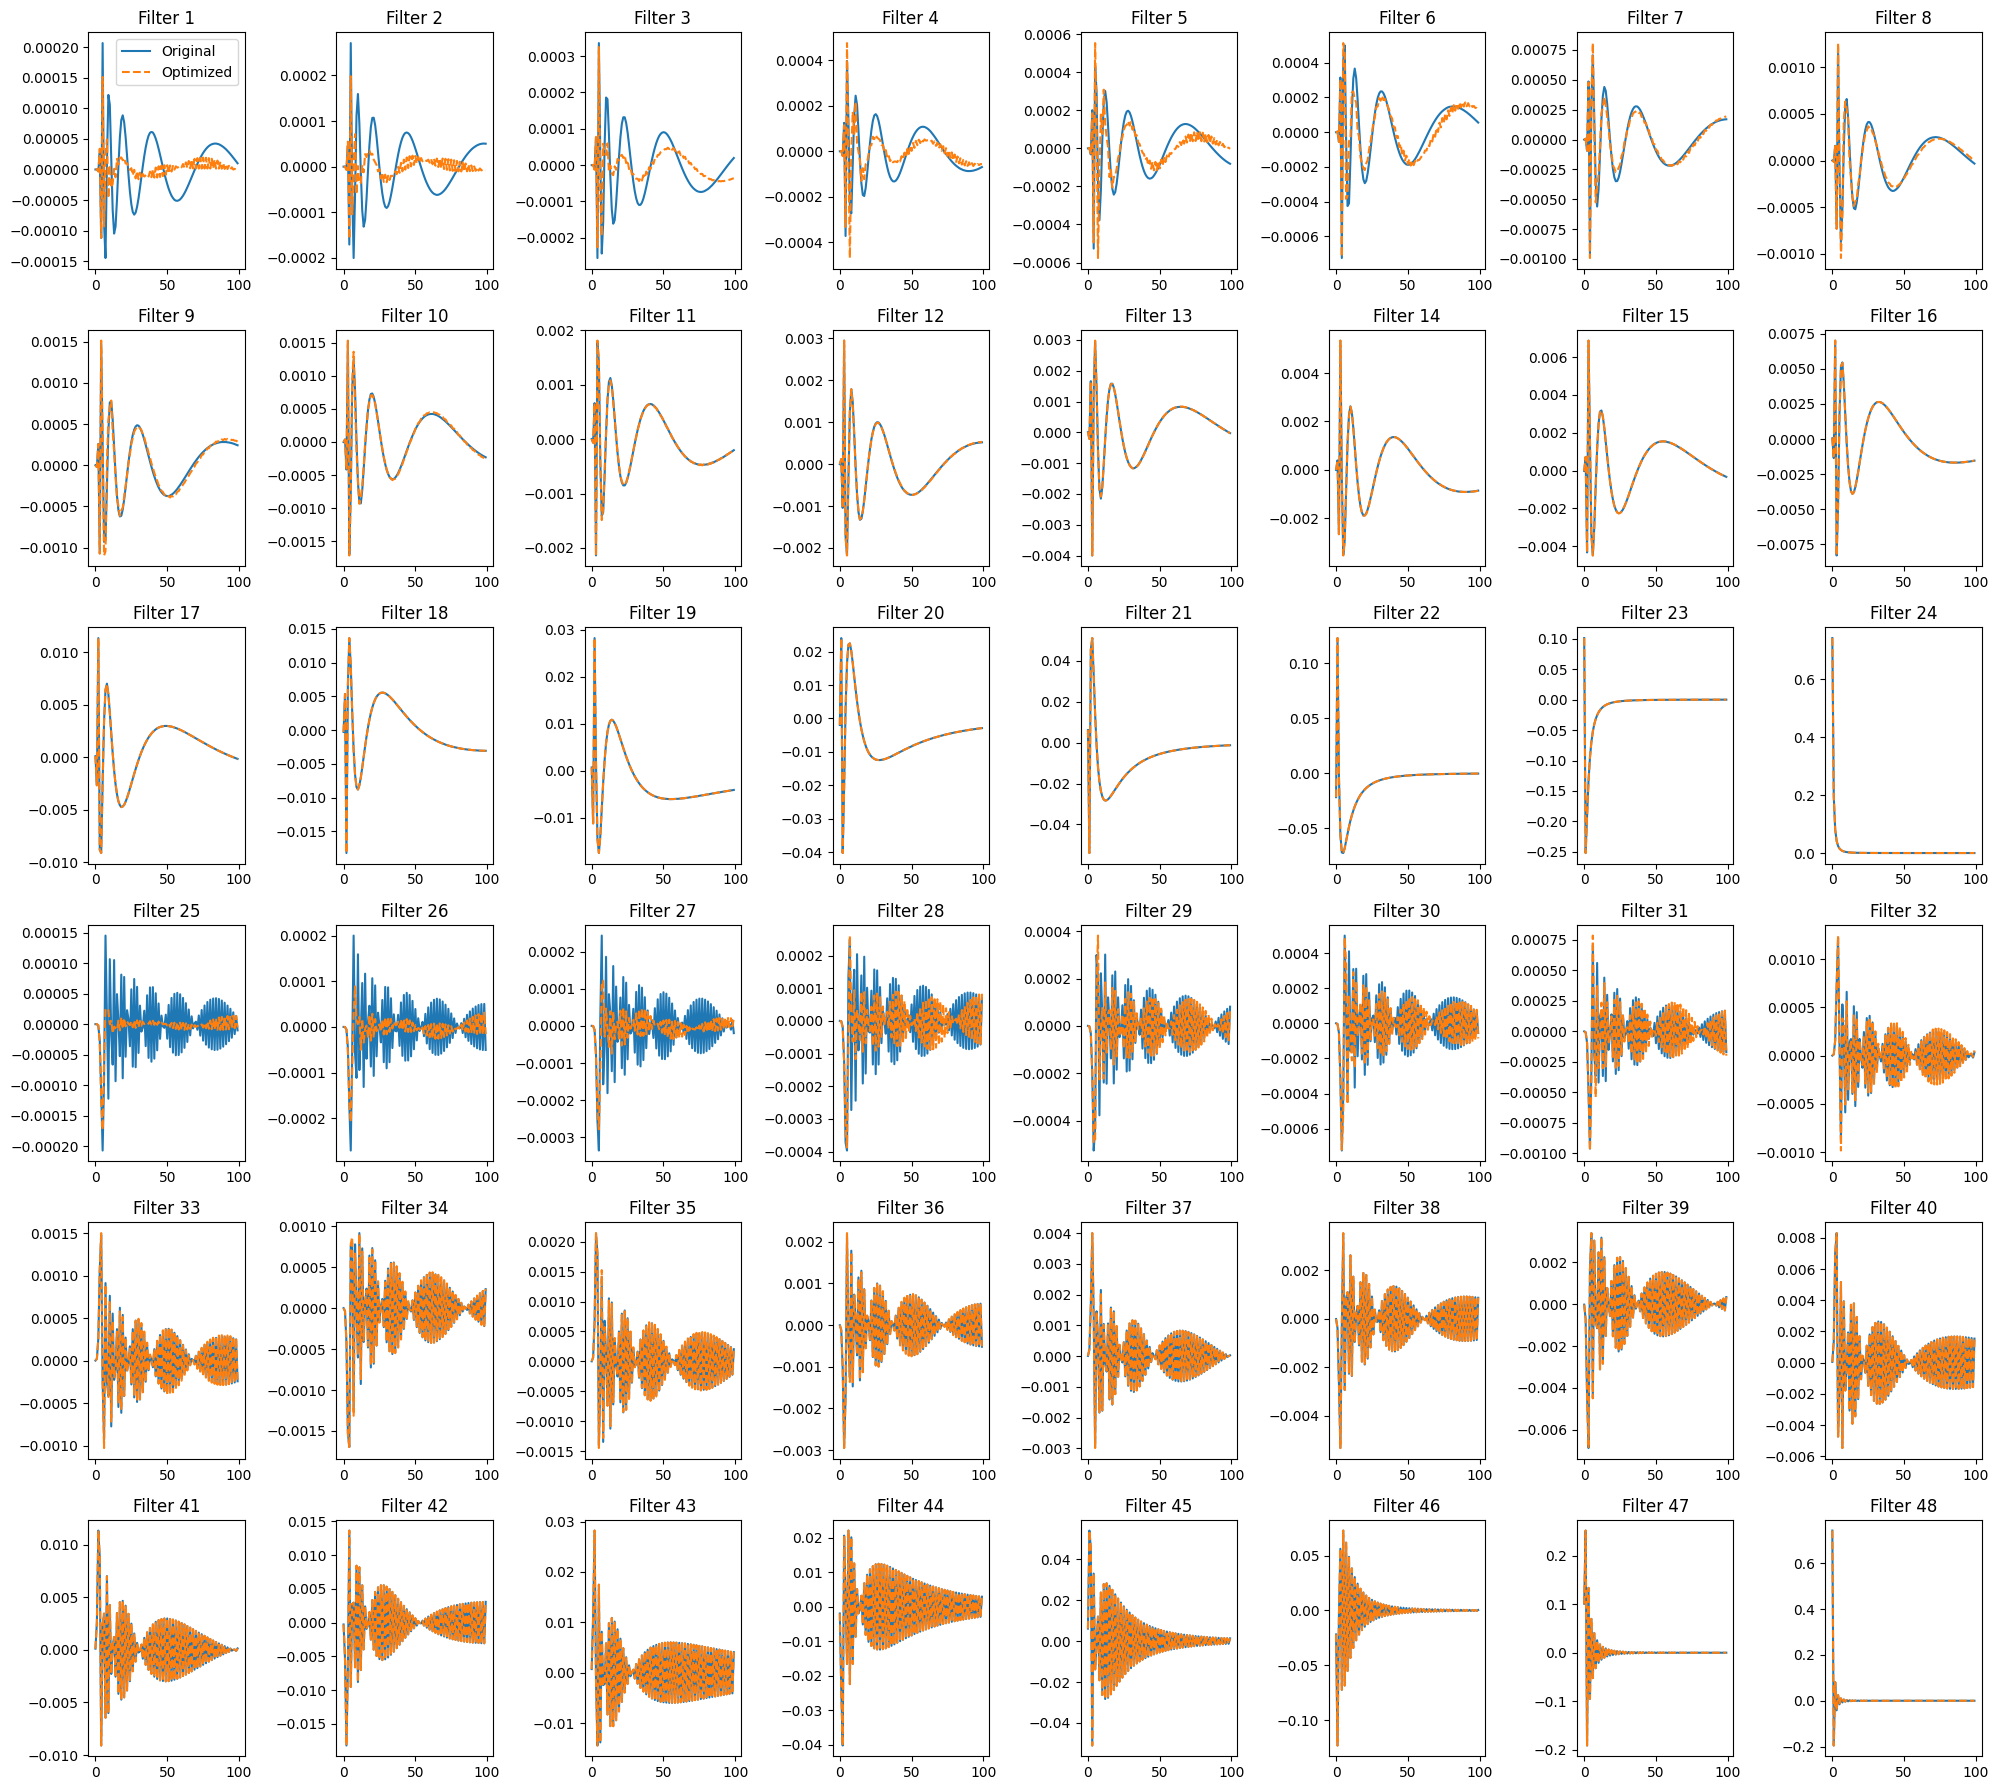

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95742/3800471474.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(phi_n_improved[:, i])


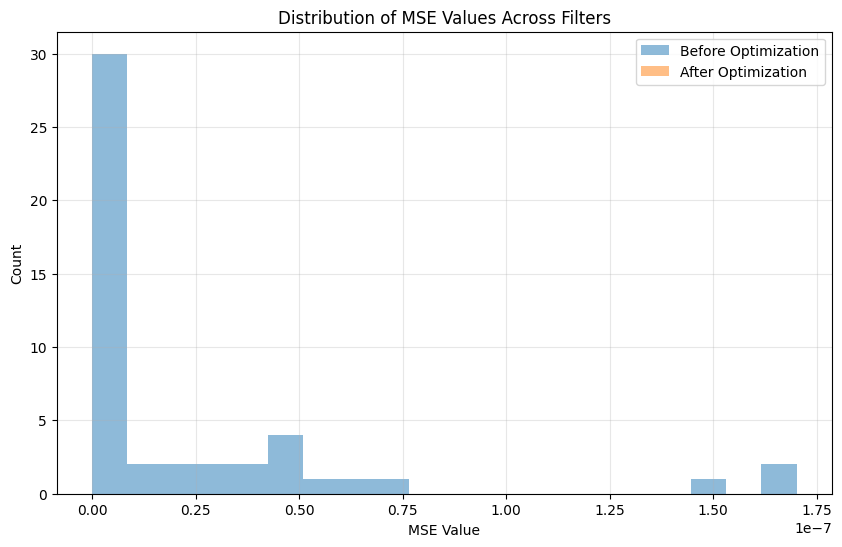

In [44]:
# Perform gradient descent to improve the reconstruction
print("Starting gradient descent optimization...")

# Convert to PyTorch tensors
phi_n_combined_tensor = torch.tensor(phi_n_combined, dtype=torch.float32)
combined_weights_pinv_tensor = torch.tensor(combined_weights_pinv, dtype=torch.float32, requires_grad=True)
lds_impulses_tensor = torch.tensor(lds_impulses)

# Initialize optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam([combined_weights_pinv_tensor], lr=learning_rate)

# Training parameters
num_steps = 500000
print_interval = 5000

# Training loop
losses = []
for step in range(num_steps + 1):
    # Forward pass: compute approximated phi
    phi_n_approx_tensor = torch.matmul(lds_impulses_tensor.T, combined_weights_pinv_tensor)
    
    # Compute loss
    loss = F.mse_loss(phi_n_approx_tensor, phi_n_combined_tensor)
    
    # Store loss
    losses.append(loss.item())
    
    # Print progress
    if step % print_interval == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss.item():.2e}")
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Get the optimized weights
optimized_weights = combined_weights_pinv_tensor.detach().numpy()

# Compute the improved approximation
phi_n_improved = lds_impulses_tensor.T @ optimized_weights

# Calculate MSE between original and improved approximation
improved_mse = F.mse_loss(
    torch.tensor(phi_n_combined), 
    torch.tensor(phi_n_improved)
).item()

print(f"MSE after optimization: {improved_mse:.2e}")
print(f"Improvement factor: {mse / improved_mse:.2f}x")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Optimization Step')
plt.ylabel('MSE Loss')
plt.title('Loss During Optimization')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Plot comparison of filters before and after optimization
plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_improved[:100, i], '--', label='Optimized')
    plt.title(f'Filter {i+1}')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate per-filter MSE for the improved approximation
improved_filter_mses = []
for i in range(num_filters):
    filter_mse = F.mse_loss(
        torch.tensor(phi_n_combined[:, i]), 
        torch.tensor(phi_n_improved[:, i])
    )
    improved_filter_mses.append(filter_mse.item())

# Plot histogram comparing MSE before and after optimization
plt.figure(figsize=(10, 6))
plt.hist(filter_mses, bins=20, alpha=0.5, label='Before Optimization')
plt.hist(improved_filter_mses, bins=20, alpha=0.5, label='After Optimization')
plt.xlabel('MSE Value')
plt.ylabel('Count')
plt.title('Distribution of MSE Values Across Filters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [45]:
# Create a directory to save the LDS and weights data
import os
import numpy as np
import torch

# Create the directory if it doesn't exist
save_dir = f"fit_first_16_{len(lds_impulses)}"
os.makedirs(save_dir, exist_ok=True)

# Save the LDS impulses as both numpy and pytorch formats
np.save(os.path.join(save_dir, "lds_impulses.npy"), lds_impulses_tensor.detach().cpu().numpy())

# Save the optimized weights as both numpy and pytorch formats
np.save(os.path.join(save_dir, "optimized_weights.npy"), optimized_weights)
torch.save(optimized_weights, os.path.join(save_dir, "optimized_weights.pth"))

# Save all the LDS models used to generate the impulses
for i, lds_model in enumerate(lds_params):
    torch.save(lds_model.state_dict(), os.path.join(save_dir, f"lds_model_{i}.pth"))
  

print(f"Saved LDS impulses (shape: {lds_impulses_tensor.shape}), weights (shape: {optimized_weights.shape}), and {len(lds_params)} LDS models to {save_dir}/ in both .npy and .pth formats")


Saved LDS impulses (shape: torch.Size([480, 8192])), weights (shape: (480, 48)), and 480 LDS models to fit_first_16_480/ in both .npy and .pth formats


In [ ]:
***Now lets use gradient descent on the LDS and the Combination matrix to improve this fit***

In [80]:
# Define the path to the saved data
save_dir = "fit_first_16_480"

combined_weights = np.load(os.path.join(save_dir, "optimized_weights.npy"))


# Load the saved LDS models
lds_params = []

# Path to the saved LDS models
lds_models_dir = save_dir

# Load all 488 LDS models
for i in range(480):
    model_path = os.path.join(lds_models_dir, f"lds_model_{i}.pth")
    if os.path.exists(model_path):
        # Load the model with weights_only=True to avoid security warnings
        model_state = torch.load(model_path, weights_only=True)
        new_lds = LDS(1, 1, 1, 0)
        new_lds.load_state_dict(model_state)
        lds_params.append(new_lds)
    

print(f"Loaded {len(lds_params)} LDS models")


Loaded 480 LDS models


In [81]:
# Extract A, B, and C matrices from all LDS models
A_matrices = []
B_matrices = []
C_matrices = []

for lds in lds_params:
    # Extract parameters from each LDS model
    A_matrices.append(lds.A.detach().clone())
    B_matrices.append(lds.B.detach().clone())
    C_matrices.append(lds.C.detach().clone())

# Stack all matrices
stacked_A = torch.stack(A_matrices)
stacked_B = torch.stack(B_matrices)
stacked_C = torch.stack(C_matrices)

# Print shapes to verify
print(f"Stacked A shape: {stacked_A.shape}")
print(f"Stacked B shape: {stacked_B.shape}")
print(f"Stacked C shape: {stacked_C.shape}")


BC = (stacked_B * stacked_C).reshape(-1)
A = stacked_A.reshape(-1)


Stacked A shape: torch.Size([480, 1])
Stacked B shape: torch.Size([480, 1, 1])
Stacked C shape: torch.Size([480, 1, 1])


In [82]:
# Convert combined weights to tensor for the model
combined_weights_tensor = torch.tensor(combined_weights, dtype=torch.float)

# Define a simple model that combines LDS impulses and weights
#this is extremely slow though. 

class LDS_Container(nn.Module):
    def __init__(self, A, BC, weights):
        super(LDS_Container, self).__init__()
        # Convert the list of LDS models to nn.ParameterList so parameters are tracked
        self.A = nn.Parameter(A)
        self.BC = nn.Parameter(BC)
        self.weights = nn.Parameter(weights)
    
    def forward(self):
       
        outputs = torch.zeros(self.A.shape[0],seq_len, device=self.A.device)
        
        # For each time step
        a_power = self.A**0
        for t in range(seq_len):
            # Compute A^t
            
            outputs[:, t] = self.BC * a_power
            a_power = a_power * self.A
  
        # Compute the output by multiplying stacked impulses with weights
        return torch.matmul(outputs.T, self.weights)

# Create the model
model = LDS_Container(A.detach(), BC.detach(), combined_weights_tensor)

In [83]:
import torch.optim as optim

# Define optimizer - optimize both LDS impulses and weights
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Define loss function
criterion = nn.MSELoss()

# Training parameters
num_epochs = 500000
print_interval = 5

# Target data (using phi_n_combined from previous cells)
target = torch.tensor(phi_n_combined, dtype=torch.float)

# Training loop
losses = []
print("Starting joint optimization of LDS impulses and weights...")
for epoch in range(num_epochs):
    # Forward pass
    optimizer.zero_grad()
    output = model()
    # Compute loss
    loss = criterion(output, target)
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    # Store loss
    losses.append(loss.item())
    
    # Print progress
    if (epoch + 1) % print_interval == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Starting joint optimization of LDS impulses and weights...
Epoch 1/500000, Loss: 6.38981922929105e-11
Epoch 5/500000, Loss: 3.8007649805216204e-10
Epoch 10/500000, Loss: 2.0060220151663088e-10
Epoch 15/500000, Loss: 1.1321481946380274e-10
Epoch 20/500000, Loss: 9.662731725867957e-11
Epoch 25/500000, Loss: 9.198863892834197e-11
Epoch 30/500000, Loss: 7.409721447526607e-11
Epoch 35/500000, Loss: 7.408142849163468e-11
Epoch 40/500000, Loss: 7.437712945534969e-11
Epoch 45/500000, Loss: 6.828919374424203e-11
Epoch 50/500000, Loss: 6.839394328661541e-11
Epoch 55/500000, Loss: 6.762484322520024e-11
Epoch 60/500000, Loss: 6.640055866258265e-11
Epoch 65/500000, Loss: 6.767430366094729e-11
Epoch 70/500000, Loss: 6.518941636501907e-11
Epoch 75/500000, Loss: 6.505217198249369e-11
Epoch 80/500000, Loss: 6.749368425262858e-11
Epoch 85/500000, Loss: 6.50305295724074e-11
Epoch 90/500000, Loss: 6.446390643510824e-11
Epoch 95/500000, Loss: 6.56531495835111e-11
Epoch 100/500000, Loss: 6.544293579269223e-

KeyboardInterrupt: 

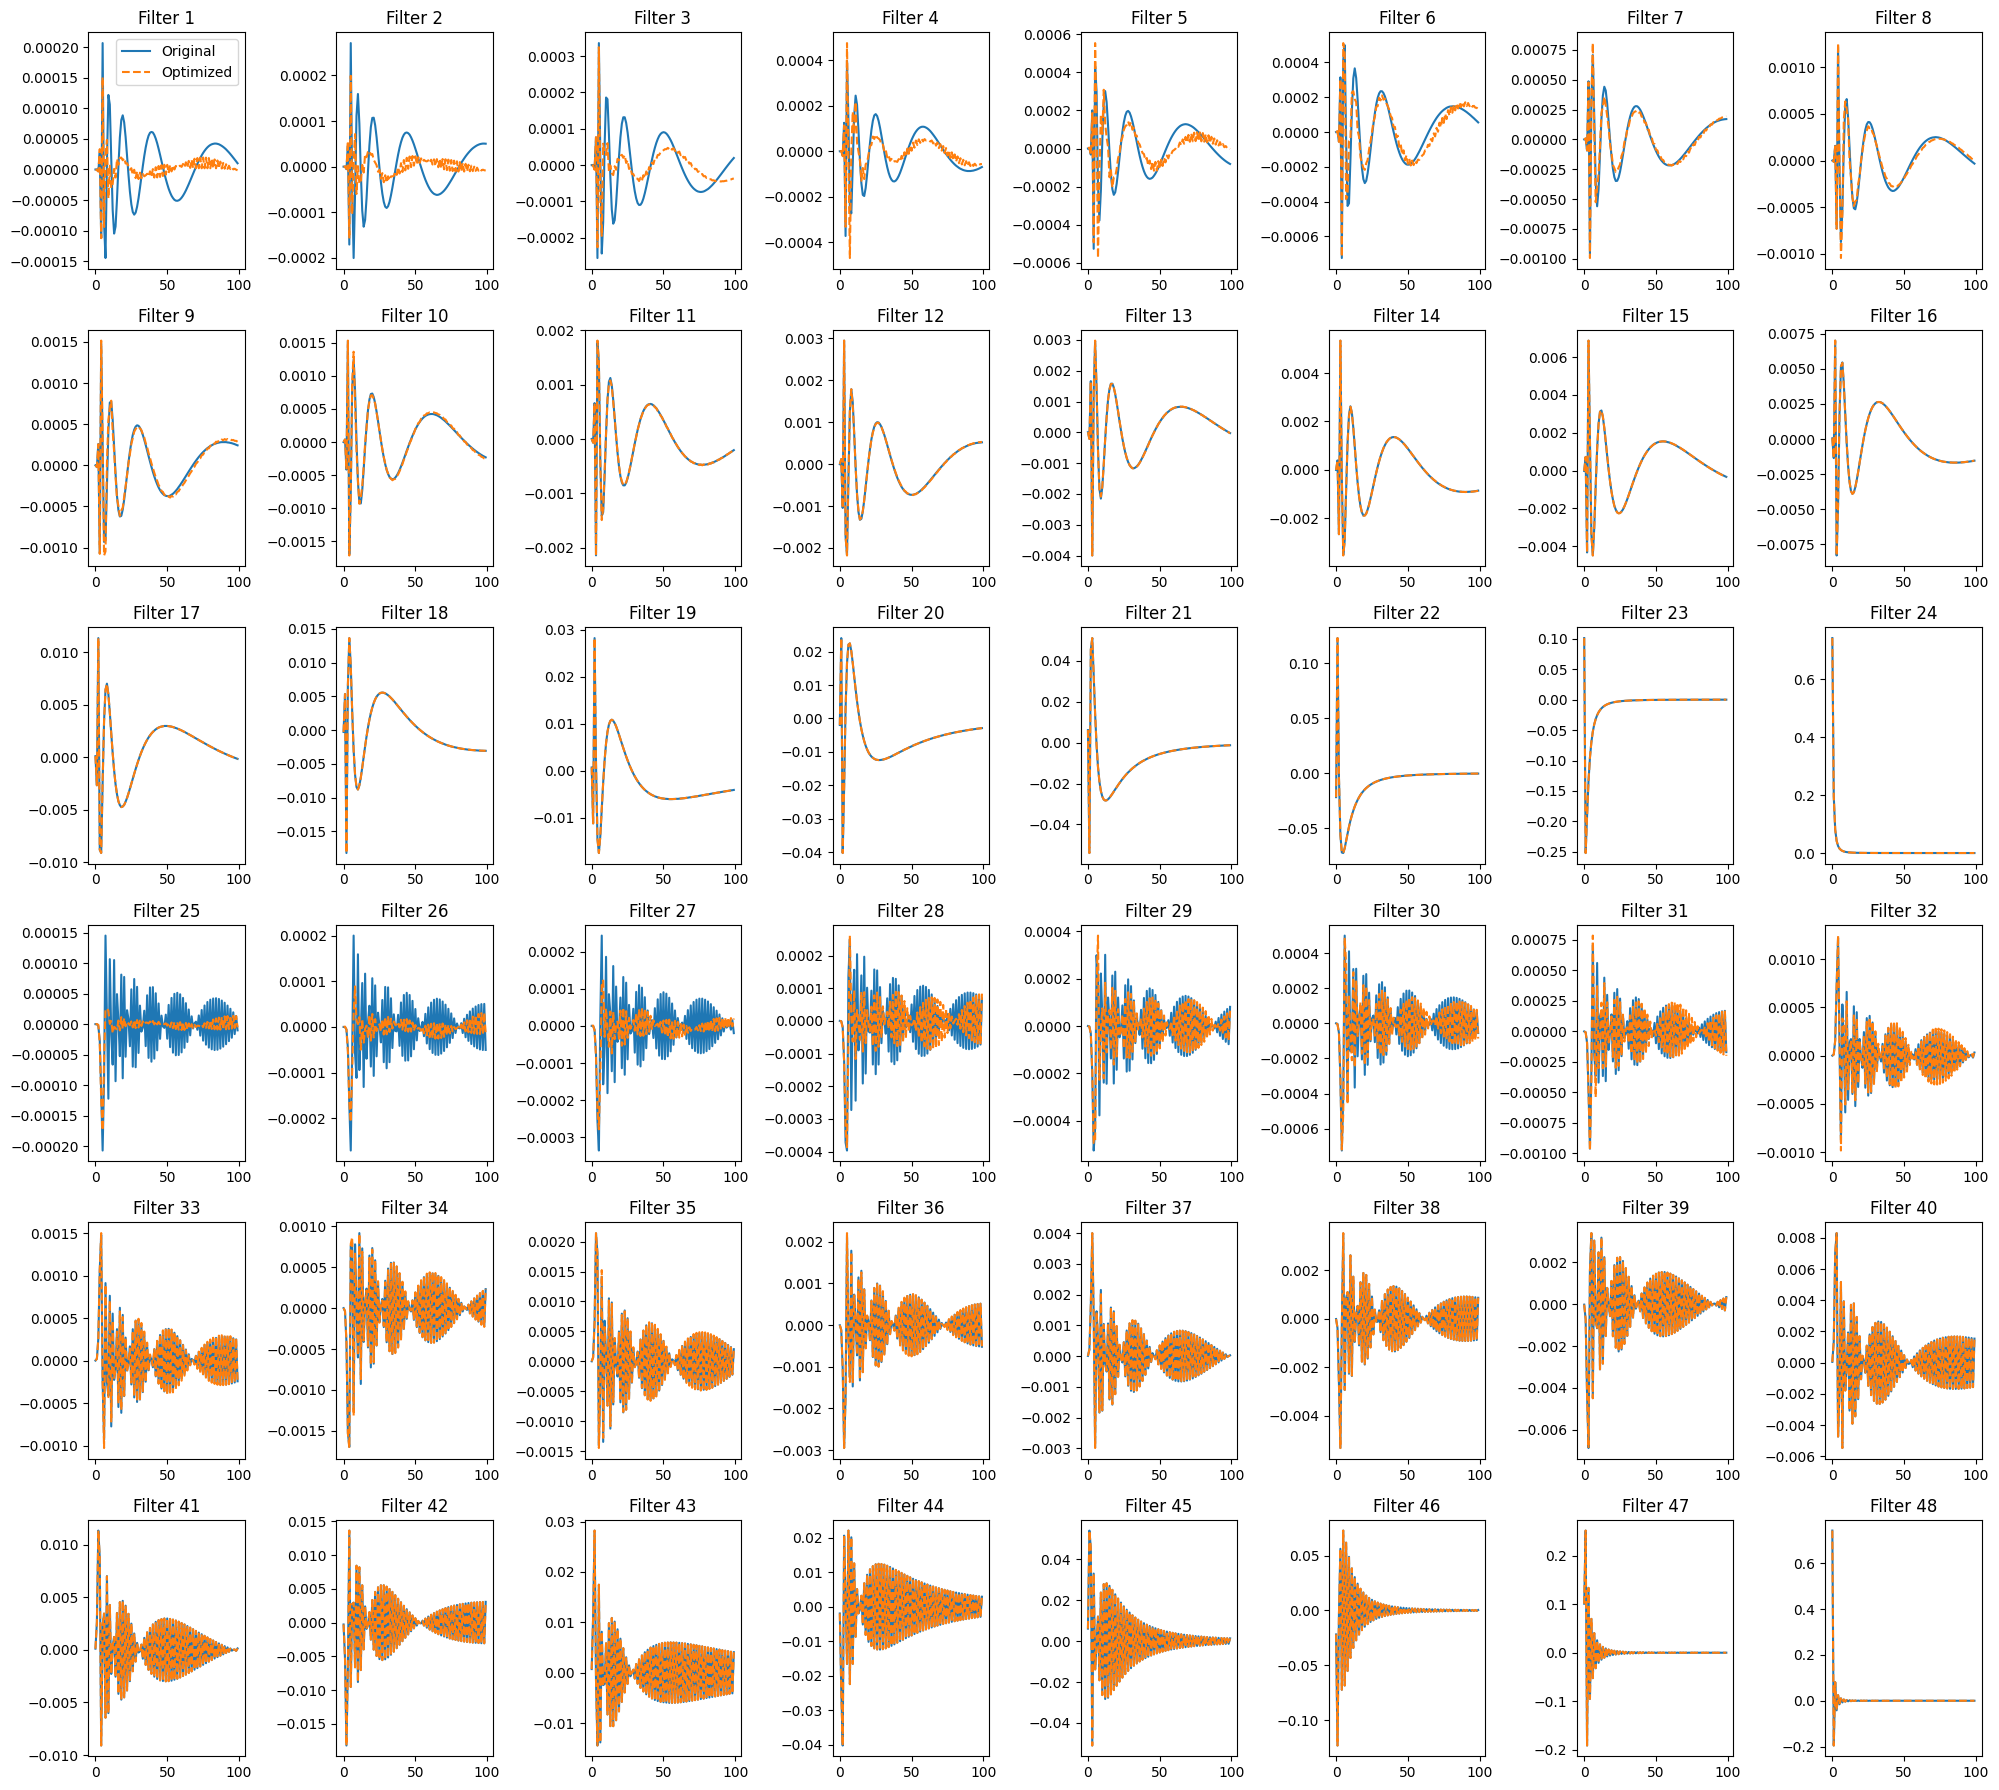

In [84]:
plt.figure(figsize=(20, num_rows * 3))
phi_n_output = model().detach()
for i in range(num_filters):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_output[:100, i], '--', label='Optimized')
    plt.title(f'Filter {i+1}')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


**Sadly was not very successful, let's see if we can dilate the filtes to fit each other**

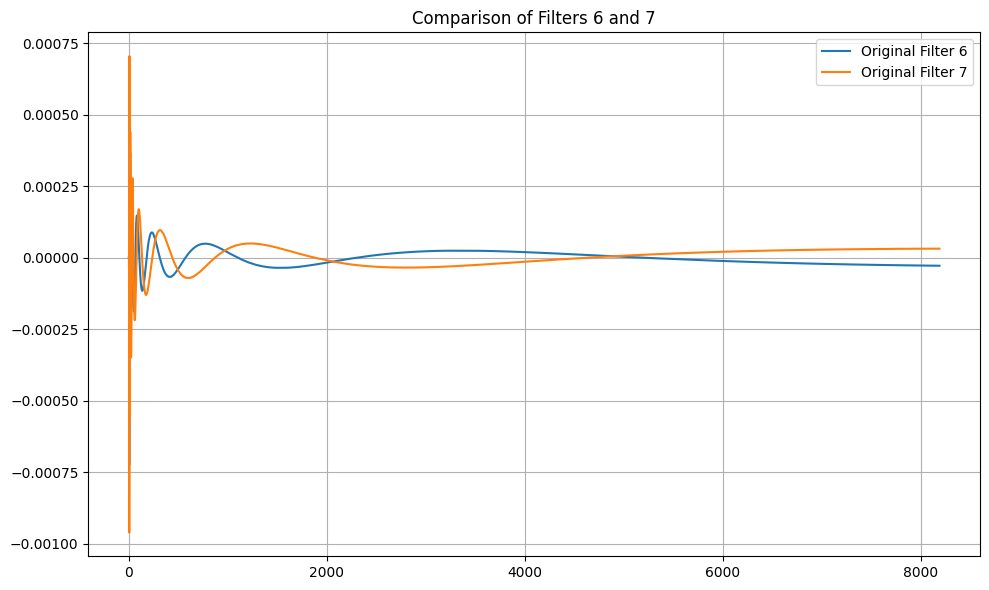

In [88]:
# Plot filter 6 and filter 7 specifically
plt.figure(figsize=(10, 6))

# Filter 6 (index 5)
plt.plot(phi_n_combined[:, 5], label='Original Filter 6')
# plt.plot(phi_n_output[:, 5], '--', label='Optimized Filter 6')

# Filter 7 (index 6)
plt.plot(phi_n_combined[:, 6], label='Original Filter 7')
# plt.plot(phi_n_output[:, 6], '--', label='Optimized Filter 7')

plt.title('Comparison of Filters 6 and 7')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Dilation factor: 1.7042716319824753


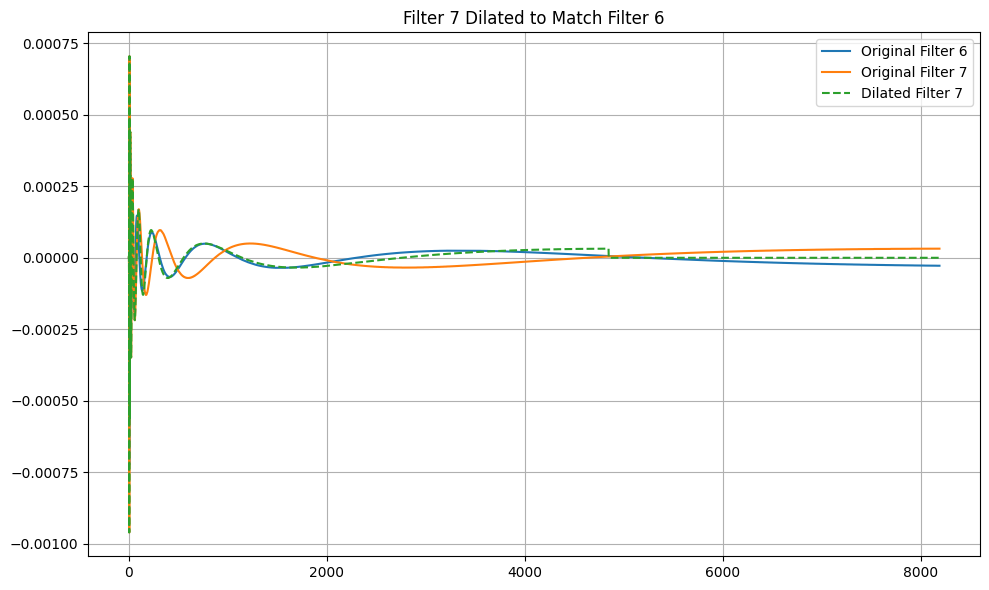

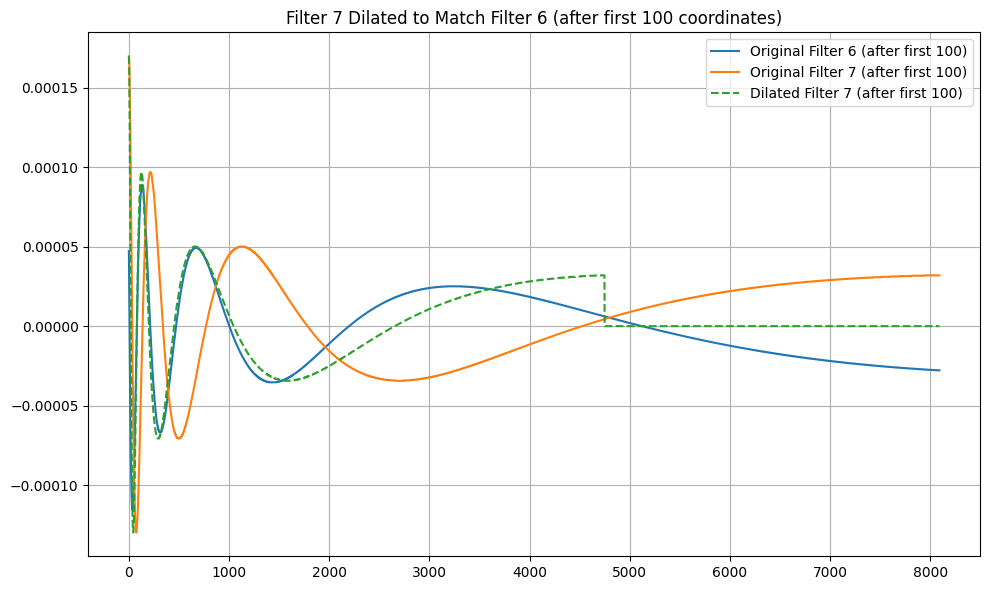

In [89]:
# Dilate filter 7 to match filter 6, ignoring the first 100 coordinates
filter_6 = phi_n_combined[:, 5]  # Original filter 6
filter_7 = phi_n_combined[:, 6]  # Original filter 7

# Determine the length of the signals
signal_length = len(filter_6)

# Ignore the first 100 coordinates
filter_6_relevant = filter_6[100:]
filter_7_relevant = filter_7[100:]

# Find the peaks in both filters to determine dilation factor
from scipy.signal import find_peaks

peaks_6, _ = find_peaks(filter_6_relevant)
peaks_7, _ = find_peaks(filter_7_relevant)

# Calculate average distance between peaks for both filters
if len(peaks_6) > 1 and len(peaks_7) > 1:
    avg_dist_6 = np.mean(np.diff(peaks_6))
    avg_dist_7 = np.mean(np.diff(peaks_7))
    
    # Calculate dilation factor
    dilation_factor = avg_dist_6 / avg_dist_7
    print(f"Dilation factor: {dilation_factor}")
else:
    # Default dilation factor if peaks can't be determined
    dilation_factor = 1.0
    print("Couldn't determine peaks properly, using default dilation factor of 1.0")

# Create a dilated version of filter 7
from scipy import interpolate

# Create original indices and new indices for interpolation
original_indices = np.arange(len(filter_7_relevant))
new_indices = np.linspace(0, len(filter_7_relevant) - 1, int(len(filter_7_relevant) / dilation_factor))

# Create interpolation function
f = interpolate.interp1d(original_indices, filter_7_relevant, kind='cubic', bounds_error=False, fill_value="extrapolate")

# Apply interpolation to get dilated filter
dilated_filter_7_relevant = f(new_indices)

# Ensure the dilated filter has the same length as the original relevant part
if len(dilated_filter_7_relevant) > len(filter_7_relevant):
    dilated_filter_7_relevant = dilated_filter_7_relevant[:len(filter_7_relevant)]
else:
    # Pad with zeros if needed
    padding = np.zeros(len(filter_7_relevant) - len(dilated_filter_7_relevant))
    dilated_filter_7_relevant = np.concatenate([dilated_filter_7_relevant, padding])

# Combine the first 100 coordinates (unchanged) with the dilated part
dilated_filter_7 = np.concatenate([filter_7[:100], dilated_filter_7_relevant])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(filter_6, label='Original Filter 6')
plt.plot(filter_7, label='Original Filter 7')
plt.plot(dilated_filter_7, '--', label='Dilated Filter 7')
plt.title('Filter 7 Dilated to Match Filter 6')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot just the relevant part (after first 100 coordinates)
plt.figure(figsize=(10, 6))
plt.plot(filter_6[100:], label='Original Filter 6 (after first 100)')
plt.plot(filter_7[100:], label='Original Filter 7 (after first 100)')
plt.plot(dilated_filter_7[100:], '--', label='Dilated Filter 7 (after first 100)')
plt.title('Filter 7 Dilated to Match Filter 6 (after first 100 coordinates)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
